## Objective

The objective of this notebook is to explore the use of transfer learning in credit risk modeling.  By building a binary classification neural network to predict default on well know and large credit data sets, such as LendingClub.com, we can test the application of transfer learning with Corning specific credit analysis.

In [50]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [89]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Activation

In [51]:
data = pd.read_csv('data/LoanStats3a_securev1.csv', index_col=0, low_memory=False)
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975.0,36 months,0.107,162.87,B,B2,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1077430,1314167,2500,2500,2500.0,60 months,0.153,59.83,C,C4,Ryder,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1077175,1313524,2400,2400,2400.0,36 months,0.160,84.33,C,C5,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1076863,1277178,10000,10000,10000.0,36 months,0.135,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1075358,1311748,3000,3000,3000.0,60 months,0.127,67.79,B,B5,University Medical Group,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [52]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Current',
       'Late (16-30 days)', 'In Grace Period', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'], dtype=object)

In [53]:
data.loc[data['loan_status'].str.contains('Status:Fully Paid'), 'loan_status'] = 'Fully Paid'
data.loc[data['loan_status'].str.contains('Status:Charged Off'), 'loan_status'] = 'Charged Off'

In [54]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Current',
       'Late (16-30 days)', 'In Grace Period', 'Default'], dtype=object)

In [55]:
data.loc[data['loan_status'] == 'Current', 'loan_status'].count()

3

In [56]:
data.loc[data['loan_status'].str.contains('Late'), 'loan_status'].count()

11

In [43]:
data.loc[data['loan_status'] == 'In Grace Period', 'loan_status'].count()

1

In [57]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,4.253500e+04,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42535.000000,42506.000000,42535.000000,...,0.0,0.0,0.0,0.0,41170.000000,42430.000000,0.0,0.0,0.0,0.0
mean,8.257026e+05,11089.722581,10821.585753,10139.830603,0.121702,322.623063,6.913656e+04,13.373043,0.152449,713.052545,...,NaN,NaN,NaN,NaN,0.045227,0.000024,NaN,NaN,NaN,NaN
std,2.795409e+05,7410.938391,7146.914675,7131.686447,0.037113,208.927216,6.409635e+04,6.726315,0.512406,36.188439,...,NaN,NaN,NaN,NaN,0.208737,0.004855,NaN,NaN,NaN,NaN
min,7.047300e+04,500.000000,500.000000,0.000000,0.054000,15.670000,1.896000e+03,0.000000,0.000000,610.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,6.384795e+05,5200.000000,5000.000000,4950.000000,0.096000,165.520000,4.000000e+04,8.200000,0.000000,685.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,8.241780e+05,9700.000000,9600.000000,8500.000000,0.120000,277.690000,5.900000e+04,13.470000,0.000000,710.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,1.033946e+06,15000.000000,15000.000000,14000.000000,0.147000,428.180000,8.250000e+04,18.680000,0.000000,740.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
max,1.314167e+06,35000.000000,35000.000000,35000.000000,0.246000,1305.190000,6.000000e+06,29.990000,13.000000,825.000000,...,NaN,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,NaN


In [141]:
train = data[['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'verification_status', 'term',
          'grade', 'sub_grade', 'home_ownership', 'dti', 'total_pymnt']]

train = train.dropna(axis=0)

In [142]:
y = (train['total_pymnt'] - train['funded_amnt']) / train['funded_amnt']

In [143]:
X = train.drop('total_pymnt', axis=1)

In [145]:
X = pd.get_dummies(X, columns=['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status'])

In [146]:
X_norm = preprocessing.normalize(X.values, norm='l2')

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=95)

In [176]:
model = Sequential()
model.add(Dense(input_dim=57, output_dim=16))
model.add(Activation('linear'))
model.add(Dense(input_dim=16, output_dim=1))
model.add(Activation('linear'))

optim = RMSprop(lr=0.0001)

model.compile(loss='mse', optimizer=optim)

In [179]:
model.fit(X_train, y_train.values, nb_epoch=300, verbose=0,
          validation_data=(X_test, y_test.values))

In [209]:
p_t = pd.DataFrame(model.predict(X_train))
y_t = pd.DataFrame(y_train)

In [219]:
y_t['pred'] = model.predict(X_train)

In [220]:
y_t.head()

,0,pred
id,,
805331,0.208659,0.099560
665781,0.063159,0.098092
679332,0.246341,0.098327
1030533,0.380357,0.107552
770806,0.136749,0.092594


In [239]:
results = y_t[y_t['pred'] > -2]

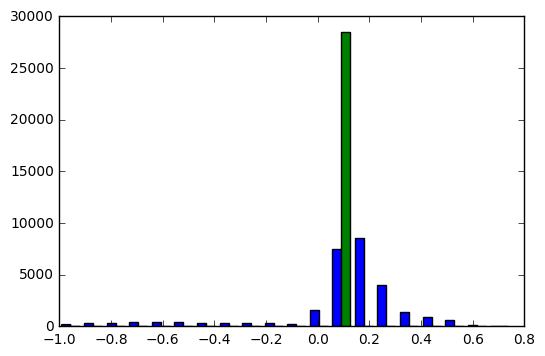

In [240]:
plt.hist(results.values, bins=20)
plt.show()

In [241]:
results.mean()

0       0.097121
pred    0.094016
dtype: float64